In [1]:
import lightgbm

print(lightgbm.__version__)

3.3.5


### LightGBM
- XGboost와 함께 부스팅 계열 알고리즘에서 각광을 받고 있는 알고리즘.
- XGboost보다 학습에 필요한 시간이 훨씬 작다. 또한 메모리 사용량도 상대적으로 적다. 그럼에도 예측 성능은 비슷한 정도를 보여준다.


### 리프 중심 트리 분할(Leaf Wise) 방식을 사용
- 기존 대부분 트리 기반 알고리즘은 균형 트리 분할 방식을 사용한다. 이는 트리의 깊이가 최소화될 수 있다는 장점을 가지나(오버피팅에 최적화) 균형을 맞추기 위한 시간이 필요하다는 단점이 있다.
- 하지만 LightGBM의 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고 **최대 손실 값(max delta loss)** 을 가지는 리프 노드를 지속적으로 분할하여 규칙 트리 생성, 예측 오류 손실을 최소화 가능. 하지만 트리의 깊이가 깊어지므로 오버피팅에는 취약한 면을 보일 수 있다.

### 주요 파라미터
- num_iteration (디폴트 = 100) : (n_estimators) 반복하려는 트리의 개수를 지정 ***LightBGM은 트리의 깊이가 매우 깊어질 수 있으므로 특히나 좋은 설정이 필요하다. 크게 지정할 수록 예측 성능이 높아지나 너무 크게 지정하면 과적합으로 성능이 저하될 수 있다.***
- learning_rate (디폴트 = 0.1) : 0과 1 사이 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값.
- max_depth (디폴트 = -1) : 일반적 트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값은 깊이에 제한이 없음을 의미
- min_data_in_leaf (디폴트 = 20) : 결정 트리의 min_samples_leaf와 같은 파라미터. 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수.
- num_leaves (디폴트 = 31) : 하나의 트리가 가질 수 있는 최대 리프 개수

#### 하이퍼 파라미터 튜닝 방안
- num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안


- - num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터이다. 이를 높이면 정확도는 높아지지만 트리 깊이가 깊어지며 복잡도가 커져 과적합 영향도가 커진다.
- - min_data_in_leaf는 사이킷런 래퍼 클래스에서 min_child_samples로 이름이 바뀐다. 과적합을 개선하기 위한 중요 파라미터이다. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.
- - max_depth는 깊이의 크기를 제한

### LightGBM 적용 – 위스콘신 Breast Cancer Prediction

In [2]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

C:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


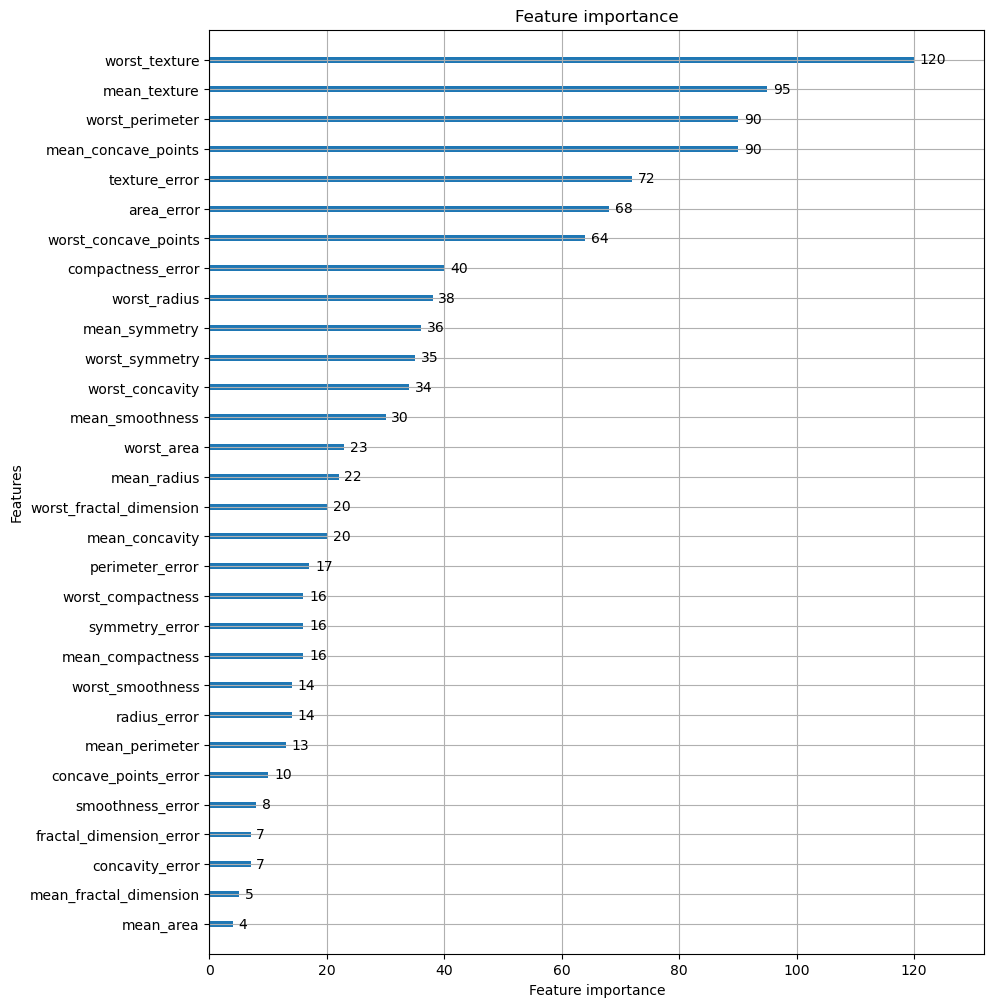

In [5]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')